In [5]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from enum import Enum

In [6]:
DATA_ROOT = Path("../../data/")
# VIDEO_NAME = Path("VID_20230814_102451798.mp4")
# VIDEO_NAME = Path("VID_20230815_160238697.mp4")
VIDEO_NAME = Path("yt/01.mp4")

# check if the video exists
if not (DATA_ROOT / VIDEO_NAME).exists():
    raise FileNotFoundError(f"Video not found: {DATA_ROOT / VIDEO_NAME}")

# open video file with opencv
video_reader = cv2.VideoCapture(str(DATA_ROOT/VIDEO_NAME))

# check if video opened successfully
if (video_reader.isOpened() == False):
    raise Exception(f"Error opening video stream or file: {DATA_ROOT/VIDEO_NAME}")
    
width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
# print video properties
print("Video properties:")
print("  - frame width:  ", width)
print("  - frame height: ", height)
print("  - frame count:  ", frames_count)
print("  - frame rate:   ", video_reader.get(cv2.CAP_PROP_FPS))

Video properties:
  - frame width:   1920
  - frame height:  1080
  - frame count:   91
  - frame rate:    29.95


In [7]:
def segment_by_homography(frame1, frame2) -> tuple[np.ndarray, np.ndarray]:
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    # find keypoints and descriptors
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(gray1, None)
    kp2, des2 = orb.detectAndCompute(gray2, None)

    # match features
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    # matches = sorted(matches, key=lambda x: x.distance)

    matched_keypoints1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    matched_keypoints2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # calculate homography matrix
    homography_matrix1, inliers = cv2.findHomography(matched_keypoints1, matched_keypoints2, cv2.RANSAC, 5.0)
    inliers_percentage = float(inliers.sum()) / float(len(inliers))
    if inliers_percentage < 0.5:
        print("Can't find homography matrix.")
        return None, None

    # warp perspective
    rectified_image1 = cv2.warpPerspective(frame1, homography_matrix1, (frame1.shape[1], frame1.shape[0]))

    # calculate disparity map
    stereo = cv2.StereoBM_create(numDisparities=16, blockSize=31)
    gray_rectified_image1 = cv2.cvtColor(rectified_image1, cv2.COLOR_BGR2GRAY)
    disparity = stereo.compute(gray2, gray_rectified_image1)

    DISPARITY_THRESHOLD = 0
    # background_mask = (disparity < DISPARITY_THRESHOLD).astype(np.uint8)
    foreground_mask = np.where(disparity >= DISPARITY_THRESHOLD)
    background_mask = np.where(disparity < DISPARITY_THRESHOLD)

    foreground = frame2.copy()
    foreground[foreground_mask] = (0, 0, 0)
    background = frame2.copy()
    background[background_mask] = (0, 0, 0)

    return foreground, background

def segment_by_optical_flow(frame1, frame2) -> tuple[np.ndarray, np.ndarray]:
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    # create histogram of optical flow
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    
    #find the median of the magnitude
    threshold = np.median(mag)

    # Create a mask by thresholding the magnitude
    mask = mag > threshold

    # Create a mask to remove the background
    background_mask = np.where(mask == 0)
    foreground_mask = np.where(mask == 1)

    foreground = frame2.copy()
    foreground[foreground_mask] = (0, 0, 0)
    background = frame2.copy()
    background[background_mask] = (0, 0, 0)

    return foreground, background


class SegmentationMOG():
    def __init__(self) -> None:
        self.segmenter = cv2.createBackgroundSubtractorMOG2(history=100, varThreshold=25, detectShadows=False)

    def train_background(self, frame: np.ndarray) -> None:
        self.segmenter.apply(frame)

    def segment(self, frame: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        mask = self.segmenter.apply(frame)
        background_mask = np.where(mask == 0)
        foreground_mask = np.where(mask != 0)

        foreground = frame.copy()
        foreground[foreground_mask] = (0, 0, 0)
        background = frame.copy()
        background[background_mask] = (0, 0, 0)

        return foreground, background
    

class SegmentationFaceDetection():
    def __init__(self, data_folder: Path = ".", model_file: Path = "haarcascade_frontalface_default.xml") -> None:
        self.model_path = data_folder / model_file
        if not self.model_path.exists():
            raise FileNotFoundError(f"Model file {self.model_path} not found.")
        self.face_cascade = cv2.CascadeClassifier(str(data_folder / model_file))

    def segment(self, frame: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, (0, 0), fx=0.10, fy=0.10)
        min_size = (int(gray.shape[1] / 10), int(gray.shape[0] / 10))
        faces = self.face_cascade.detectMultiScale(gray,scaleFactor=1.05, minNeighbors=1, minSize=min_size)
        if len(faces) == 0:
            return None, None

        x, y, w, h = faces[0]*10
        foreground = np.zeros(frame.shape, dtype=np.uint8)
        foreground[y:y+h, x:x+w] = frame[y:y+h, x:x+w]
        background = frame.copy()
        background[y:y+h, x:x+w] = (0, 0, 0)

        return foreground, background


In [8]:

video_writer_foreground = cv2.VideoWriter(str(DATA_ROOT/VIDEO_NAME).replace('.mp4', '_foreground.mp4'), cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))
video_writer_background = cv2.VideoWriter(str(DATA_ROOT/VIDEO_NAME).replace('.mp4', '_background.mp4'), cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))

current_frame = None
video_reader.set(cv2.CAP_PROP_POS_FRAMES, 0)
for frame_index in tqdm(range(frames_count-1)):
    if current_frame is None:
        _, current_frame = video_reader.read()
    _, next_frame = video_reader.read()

    # Segmentation
    foreground, background = segment_by_homography(current_frame, next_frame)
    if foreground is not None and background is not None:
        # Save
        video_writer_foreground.write(foreground)
        video_writer_background.write(background)

    current_frame = next_frame

video_writer_foreground.release()
video_writer_background.release()

  0%|          | 0/90 [00:00<?, ?it/s]

100%|██████████| 90/90 [00:20<00:00,  4.47it/s]


In [9]:

video_writer_foreground = cv2.VideoWriter(str(DATA_ROOT/VIDEO_NAME).replace('.mp4', '_foreground2.mp4'), cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))
video_writer_background = cv2.VideoWriter(str(DATA_ROOT/VIDEO_NAME).replace('.mp4', '_background2.mp4'), cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))

current_frame = None
video_reader.set(cv2.CAP_PROP_POS_FRAMES, 0)
for frame_index in tqdm(range(frames_count-1)):
    if current_frame is None:
        _, current_frame = video_reader.read()
    _, next_frame = video_reader.read()

    # Segmentation
    foreground, background = segment_by_optical_flow(current_frame, next_frame)
    if foreground is not None and background is not None:
        # Save
        video_writer_foreground.write(foreground)
        video_writer_background.write(background)

    current_frame = next_frame

video_writer_foreground.release()
video_writer_background.release()

100%|██████████| 90/90 [00:56<00:00,  1.60it/s]


In [10]:
video_writer_foreground = cv2.VideoWriter(str(DATA_ROOT/VIDEO_NAME).replace('.mp4', '_foreground3.mp4'), cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))
video_writer_background = cv2.VideoWriter(str(DATA_ROOT/VIDEO_NAME).replace('.mp4', '_background3.mp4'), cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))

mog_segmenter = SegmentationMOG()
video_reader.set(cv2.CAP_PROP_POS_FRAMES, 0)
for frame_index in tqdm(range(frames_count)):
    _, current_frame = video_reader.read()
    mog_segmenter.train_background(current_frame)

video_reader.set(cv2.CAP_PROP_POS_FRAMES, 0)
for frame_index in tqdm(range(frames_count)):
    _, current_frame = video_reader.read()

    # Segmentation
    foreground, background = mog_segmenter.segment(current_frame)
    if foreground is not None and background is not None:
        # Save
        video_writer_foreground.write(foreground)
        video_writer_background.write(background)

video_writer_foreground.release()
video_writer_background.release()

100%|██████████| 91/91 [00:13<00:00,  6.87it/s]


In [12]:
video_writer_foreground = cv2.VideoWriter(str(DATA_ROOT/VIDEO_NAME).replace('.mp4', '_foreground4.mp4'), cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))
video_writer_background = cv2.VideoWriter(str(DATA_ROOT/VIDEO_NAME).replace('.mp4', '_background4.mp4'), cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))
face_segmenter = SegmentationFaceDetection(data_folder=DATA_ROOT)

video_reader.set(cv2.CAP_PROP_POS_FRAMES, 0)
for frame_index in tqdm(range(frames_count)):
    _, current_frame = video_reader.read()

    # Segmentation
    foreground, background = face_segmenter.segment(current_frame)
    if foreground is not None and background is not None:
        # Save
        video_writer_foreground.write(foreground)
        video_writer_background.write(background)

video_writer_foreground.release()
video_writer_background.release()

100%|██████████| 91/91 [00:04<00:00, 18.99it/s]


In [14]:
# stereo, optical flow, mog, face detection
stereo_foregrounds = []
optical_foregrounds = []
mog_foregrounds = []
face_foregrounds = []
all_frames = []

mog_segmenter = SegmentationMOG()
video_reader.set(cv2.CAP_PROP_POS_FRAMES, 0)
for frame_index in tqdm(range(frames_count)):
    _, current_frame = video_reader.read()
    mog_segmenter.train_background(current_frame)

face_segmenter = SegmentationFaceDetection(data_folder=DATA_ROOT)

current_frame = None
video_reader.set(cv2.CAP_PROP_POS_FRAMES, 0)
for frame_index in tqdm(range(frames_count-1)):
    if current_frame is None:
        _, current_frame = video_reader.read()
    _, next_frame = video_reader.read()

    all_frames.append(current_frame)
    # Segmentation
    foreground, _ = segment_by_homography(current_frame, next_frame)
    stereo_foregrounds.append(foreground)
    foreground, _ = segment_by_optical_flow(current_frame, next_frame)
    optical_foregrounds.append(foreground)
    foreground, _ = mog_segmenter.segment(next_frame)
    mog_foregrounds.append(foreground)
    foreground, _ = face_segmenter.segment(next_frame)
    face_foregrounds.append(foreground)
    

    current_frame = next_frame


  0%|          | 0/91 [00:00<?, ?it/s]

100%|██████████| 90/90 [01:15<00:00,  1.19it/s]


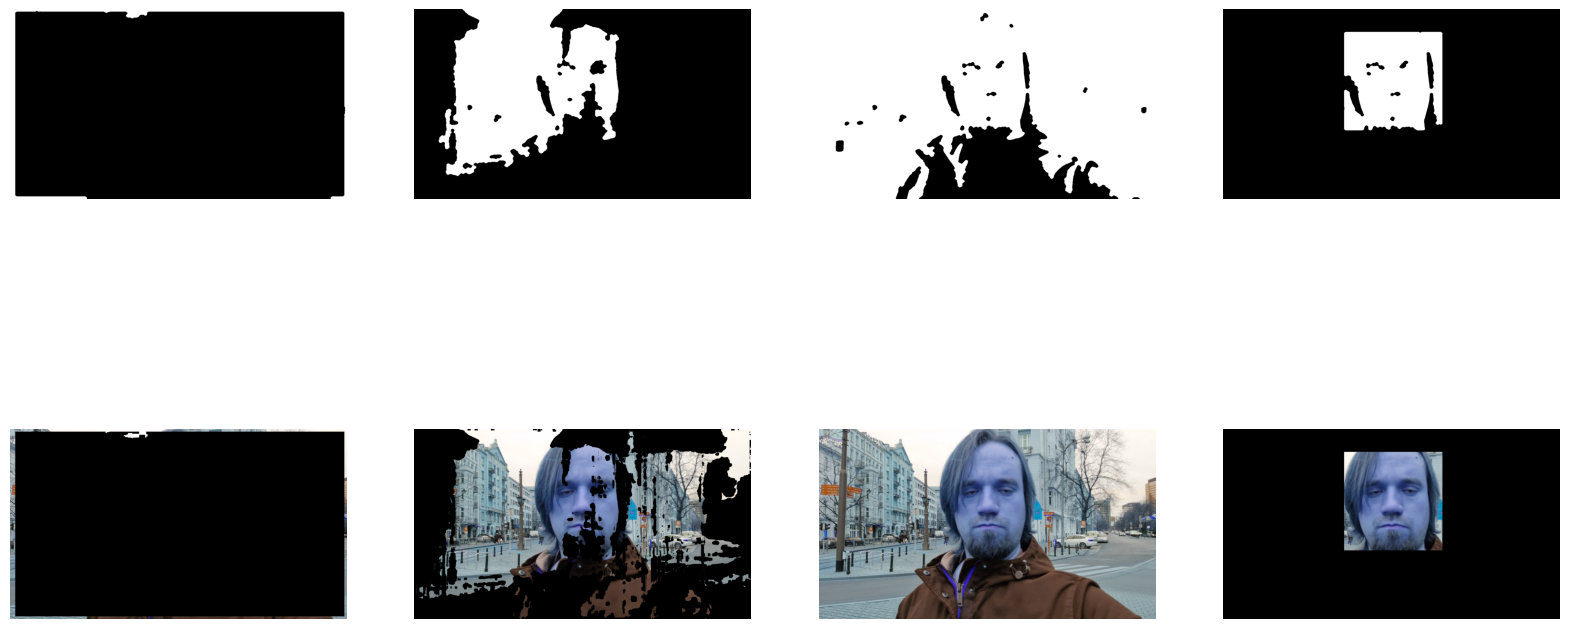

In [15]:
def segmentation_refinement(img: np.ndarray) -> np.ndarray:
    """Refine the segmentation mask using morphological operations."""
    # check if the input image is grayscale
    if len(img.shape) == 3:
        input_mask = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        # make sure the the image is uint8
        input_mask = img.copy().astype(np.uint8)
    input_mask = cv2.threshold(input_mask, 64, 255, cv2.THRESH_BINARY)[1]

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    mask = cv2.morphologyEx(input_mask, cv2.MORPH_CLOSE, kernel, iterations=3)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=3)

    # get the largest connected component
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    mask = np.zeros_like(labels)
    mask[labels == largest_label] = 255

    return mask

all_foregrounds = [stereo_foregrounds, optical_foregrounds, mog_foregrounds, face_foregrounds]
foregrounds_count = len(all_foregrounds)
sample_index = 0
for index in range(len(stereo_foregrounds)):  
    # set index if all the foreground in all_foregrounds at 'index' is not None
    if all([all_foregrounds[i][index] is not None for i in range(foregrounds_count)]):
        sample_index = index
        break

# plot all segmentation masks
fig, axes = plt.subplots(2, foregrounds_count, figsize=(20, 10))
for i, foreground in enumerate(all_foregrounds):
    segment_mask = segmentation_refinement(all_foregrounds[i][sample_index])
    axes[0, i].imshow(segment_mask, cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(all_foregrounds[i][sample_index])
    axes[1, i].axis('off')

plt.show()

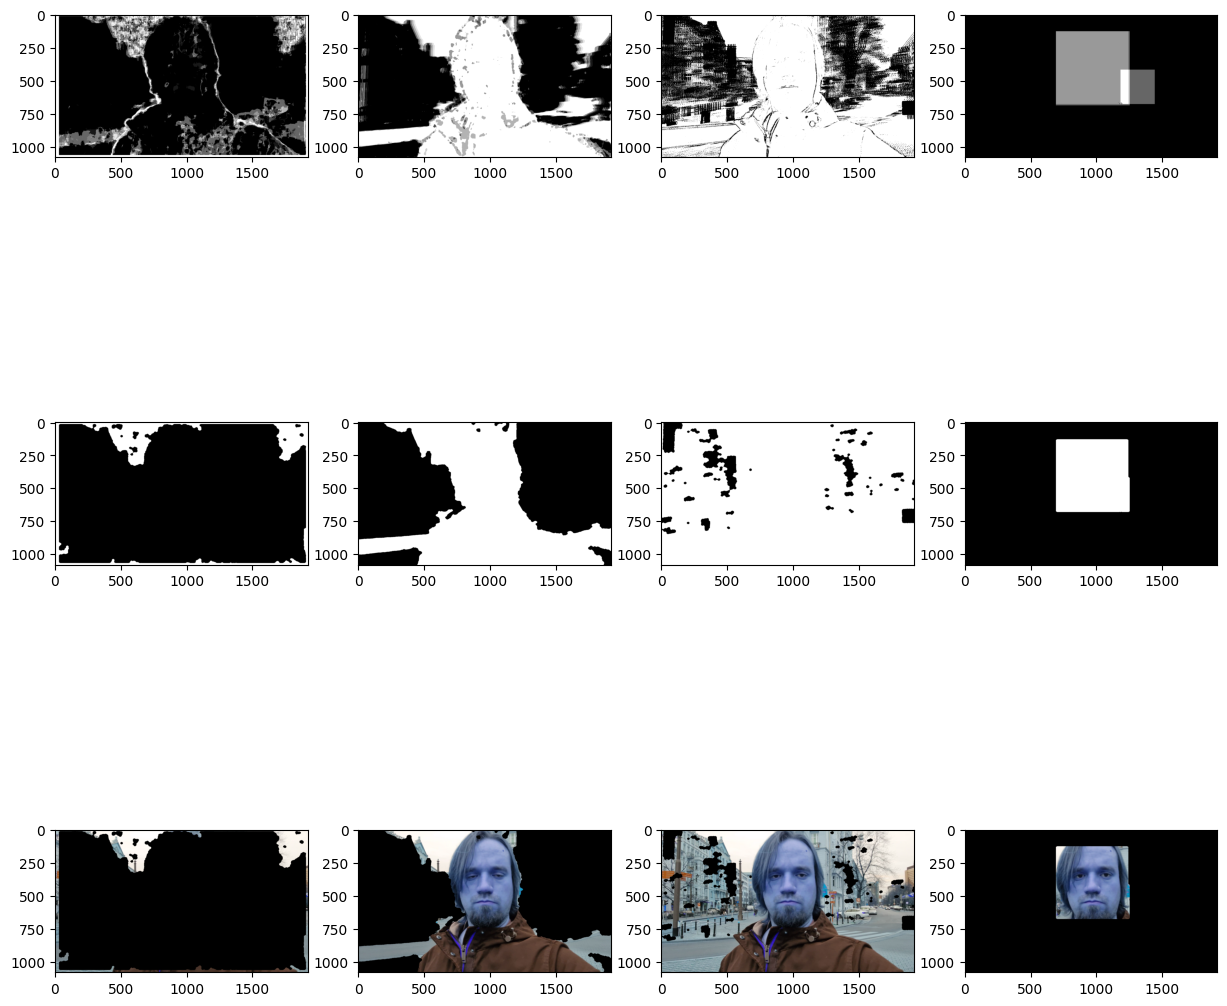

In [16]:
class AveragingMethod(Enum):
    WEIGHTED_MEAN = 0
    ALL = 1

def average_segmentation_over_time(images: list[np.ndarray], mode: AveragingMethod = AveragingMethod.WEIGHTED_MEAN) -> np.ndarray:
    # weighted average of the segmentation masks
    # the middle frames are weighted more than the first and last frames
    input_masks = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]
    input_masks = [cv2.threshold(input_mask, 1, 255, cv2.THRESH_BINARY)[1] for input_mask in input_masks]

    if mode == AveragingMethod.WEIGHTED_MEAN:
        # weights
        weights = np.linspace(0, 1, len(images))
        weights = np.concatenate((weights, weights[::-1]))

        # normalize weights
        weights = weights / np.sum(weights)

        # average
        output_mask = np.zeros_like(input_masks[0], dtype=np.float32)
        for input_mask, weight in zip(input_masks, weights):
            output_mask += input_mask * weight

        return output_mask.astype(np.uint8)
    elif mode == AveragingMethod.ALL:
        # use and operation to get the pixels that are white in all images
        output_mask = np.ones_like(input_masks[0], dtype=np.uint8) * 255
        for input_mask in input_masks:
            output_mask = cv2.bitwise_and(output_mask, input_mask)

        return output_mask
    raise ValueError("Invalid averaging method")

time_average_methods = [AveragingMethod.WEIGHTED_MEAN, AveragingMethod.WEIGHTED_MEAN, AveragingMethod.ALL, AveragingMethod.WEIGHTED_MEAN]
fig, axs = plt.subplots(3, len(all_foregrounds), figsize=(15, 15))
for i, (foregrounds, method) in enumerate(zip(all_foregrounds, time_average_methods)):
    average_mask = average_segmentation_over_time(foregrounds[5:10], method)
    refined_mask = segmentation_refinement(average_mask)
    refined_mask = refined_mask.astype(np.uint8)
    masked_image = cv2.bitwise_and(all_frames[i], all_frames[i], mask=refined_mask)

    axs[0, i].imshow(average_mask, cmap='gray')
    axs[1, i].imshow(refined_mask, cmap='gray')
    axs[2, i].imshow(masked_image)

plt.show()



In [17]:
window_size = 15

video_writer_w1 = cv2.VideoWriter(str(DATA_ROOT/VIDEO_NAME).replace('.mp4', '_foreground_w12.mp4'), cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))
video_writer_w2 = cv2.VideoWriter(str(DATA_ROOT/VIDEO_NAME).replace('.mp4', '_background_w22.mp4'), cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))
# video_writer_wc = cv2.VideoWriter(str(DATA_ROOT/VIDEO_NAME).replace('.mp4', '_background_wc.mp4'), cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))
for frame_index in tqdm(range(frames_count-1)):
    start_frame = max(0, frame_index - window_size)
    end_frame = min(frames_count-1, frame_index + window_size)

    average_mask = average_segmentation_over_time(all_foregrounds[0][start_frame:end_frame], AveragingMethod.WEIGHTED_MEAN)
    refined_mask = segmentation_refinement(average_mask).astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    refined_mask = cv2.morphologyEx(refined_mask, cv2.MORPH_CLOSE, kernel, iterations=5)
    refined_mask = cv2.morphologyEx(refined_mask, cv2.MORPH_ERODE, kernel, iterations=5)
    masked_image = cv2.bitwise_and(all_frames[frame_index], all_frames[frame_index], mask=refined_mask)
    video_writer_w1.write(masked_image)

    average_mask = average_segmentation_over_time(all_foregrounds[1][start_frame:end_frame], AveragingMethod.WEIGHTED_MEAN)
    refined_mask = segmentation_refinement(average_mask).astype(np.uint8)
    refined_mask = cv2.morphologyEx(refined_mask, cv2.MORPH_CLOSE, kernel, iterations=5)
    refined_mask = cv2.morphologyEx(refined_mask, cv2.MORPH_ERODE, kernel, iterations=5)
    masked_image = cv2.bitwise_and(all_frames[frame_index], all_frames[frame_index], mask=refined_mask)
    video_writer_w2.write(masked_image)

video_writer_w1.release()
video_writer_w2.release()

100%|██████████| 90/90 [01:07<00:00,  1.34it/s]
